## Coding session part 1 : introduction to explainability and interpretability 

The goal of this coding session is to understand the fundamentals of applied explainability and interpretability. We will focus on simple principles such as how to interpret a basic model, how to use a database to make explanations more relevant. At the end of this session you should be able to : 
1. Interpret the coefficients of a linear regression globally and locally
2. Interpret a decision tree model globally and locally 
3. Code and interpret an partial dependence plot 
4. Code a simple version of LIME  

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn import tree as tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

## Loading a toy dataset + one hot encoder

In [2]:
# Load data 
categorical_features = [
    'sex', 'marital_status',
    'relationship', #'education'
]
feature_names = [
    'age', 'education_num', # 'education',
    'marital_status',
    'relationship', 'sex', 'hours_per_week',
]

data = pd.read_csv("./adult.csv")
data.drop('fnlwgt', axis=1, inplace=True)
data.drop('race', axis=1, inplace=True)
# preprocess
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)
data.replace(
    ['Divorced', 'Married-AF-spouse',
     'Married-civ-spouse', 'Married-spouse-absent',
     'Never-married', 'Separated', 'Widowed'],
    ['divorced', 'married', 'married', 'married',
     'not married', 'not married', 'not married'], 
    inplace=True)
data.reset_index(drop=True, inplace=True)
data['Income'] = data['Income'].apply(lambda x: x.replace('.', ''))
del data['occupation'], data['workclass']

# format output variable as a 0/1 output
data['Income'] = (data['Income'] == '>50K').astype(int)
x, y = data[feature_names], data['Income']

# encoding categorical features 
non_cate_features = [x for x in feature_names if x not in categorical_features]
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
one_hot_encoder = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)],
    remainder='passthrough',
    sparse_threshold=0,
)
one_hot_encoder.fit(x)
x_encoded = one_hot_encoder.transform(x)
cate_fnames = one_hot_encoder.transformers_[0][1]['onehot'].get_feature_names()

# put column name in the encoded feature name
cate_fname_full = [categorical_features[int(f.split('_')[0][1:])] + '__is__' + f[3:] for f in cate_fnames]
non_cate_features = [x for x in feature_names if x not in categorical_features]
col_names = list(cate_fname_full) + list(non_cate_features)
encoded_samples = pd.DataFrame(data=x_encoded, columns=col_names)
encoded_feature_names = encoded_samples.columns


# output of this cell 
feature_names # name of the features 
categorical_features # name of categorical features 
x, y # original data 
encoded_samples, y # one hot encoded data (pandas dataframe)
encoded_feature_names # names of encoded features
print()

## 1. Interpret a linear model 

### 1.1 Global interpretation  

Steps : 
1. Train a linear regression model (Lasso) categorize the output value with a threshold (don't spend too much time on accuracy) 
2. Display the coefficients of the linear model (ideally with a sorted horizontal bar plot)
3. Interpret the coefficient values 
  - how data normalization impacts the value of the coefficient ? 
  - what is the correct normalization that one would expect ? why ? 

In [5]:
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

# Lasso linear regression model
model = Lasso(alpha=0.01)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.94      0.89     10230
           1       0.71      0.45      0.55      3337

    accuracy                           0.82     13567
   macro avg       0.77      0.69      0.72     13567
weighted avg       0.81      0.82      0.80     13567



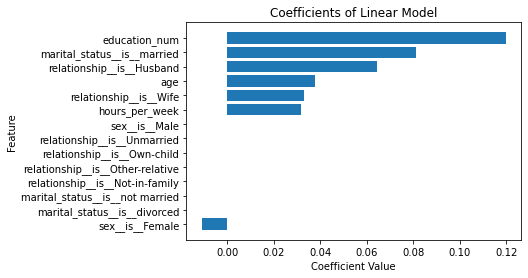

sex__is__Female : -0.011168088854883382
sex__is__Male : 1.7979308854790095e-18
marital_status__is__divorced : -0.0
marital_status__is__married : 0.08106021272090247
marital_status__is__not married : -0.0
relationship__is__Husband : 0.06455594340010128
relationship__is__Not-in-family : -0.0
relationship__is__Other-relative : -0.0
relationship__is__Own-child : -0.0
relationship__is__Unmarried : -0.0
relationship__is__Wife : 0.03284857066997839
age : 0.037750940514999526
education_num : 0.11989116749567637
hours_per_week : 0.03154315343500563


In [8]:
# Display coefficients of linear model
import matplotlib.pyplot as plt

coef = model.coef_
sorted_coef_index = np.argsort(coef)
sorted_coef = coef[sorted_coef_index]
sorted_names = np.array(encoded_feature_names)[sorted_coef_index]

plt.barh(sorted_names, sorted_coef)
plt.title("Coefficients of Linear Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

# Interpret the coefficient values
for name, coef in zip(encoded_feature_names, model.coef_):
    print(name, ":", coef)

### 1.2 Local interpretation 

Using the same linear model, provide a local explanation of the output for specific samples. 

Steps : 
1. randomly select one sample among encoded_samples
2. compute the difference with the population average
3. apply model coefficients to these differences 
4. interpret the restults 

In [22]:
# Select a random sample
sample_idx = np.random.randint(len(encoded_samples))
sample = encoded_samples.iloc[sample_idx]

# Compute the difference between the sample and the population average
diff = sample - np.mean(encoded_samples, axis=0)

# Apply model coefficients to the differences
local_coef = diff * model.coef_

# Interpret the results
for name, coef, local in zip(encoded_feature_names, model.coef_, local_coef):
    print(name,  ", local coef =", local)

sex__is__Female , local coef = 0.003629097910806937
sex__is__Male , local coef = 5.842420583369609e-19
marital_status__is__divorced , local coef = 0.0
marital_status__is__married , local coef = -0.03878780113810996
marital_status__is__not married , local coef = -0.0
relationship__is__Husband , local coef = -0.026646349995716474
relationship__is__Not-in-family , local coef = -0.0
relationship__is__Other-relative , local coef = 0.0
relationship__is__Own-child , local coef = 0.0
relationship__is__Unmarried , local coef = 0.0
relationship__is__Wife , local coef = -0.0015188704893840347
age , local coef = -0.17168906025603484
education_num , local coef = 0.7051446922883225
hours_per_week , local coef = -0.029588010825693248


## 2. Interpret a decision tree classifier 

Decision tree classifier is often presented as an easy to interpret model. Let's experiment that. 

In [10]:
# Train random forest 
X_train, X_test, y_train, y_test = train_test_split(encoded_samples, y, test_size=.33)
dt = DecisionTreeClassifier(max_leaf_nodes=20)
dt.fit(X_train, y_train)
print("Accuracy score (test dataset): ", accuracy_score(y_test, dt.predict(X_test)))

Accuracy score (test dataset):  0.8272581077459126


### 2.1 Global interpretation 

Display the decision tree classifier and interpret it 

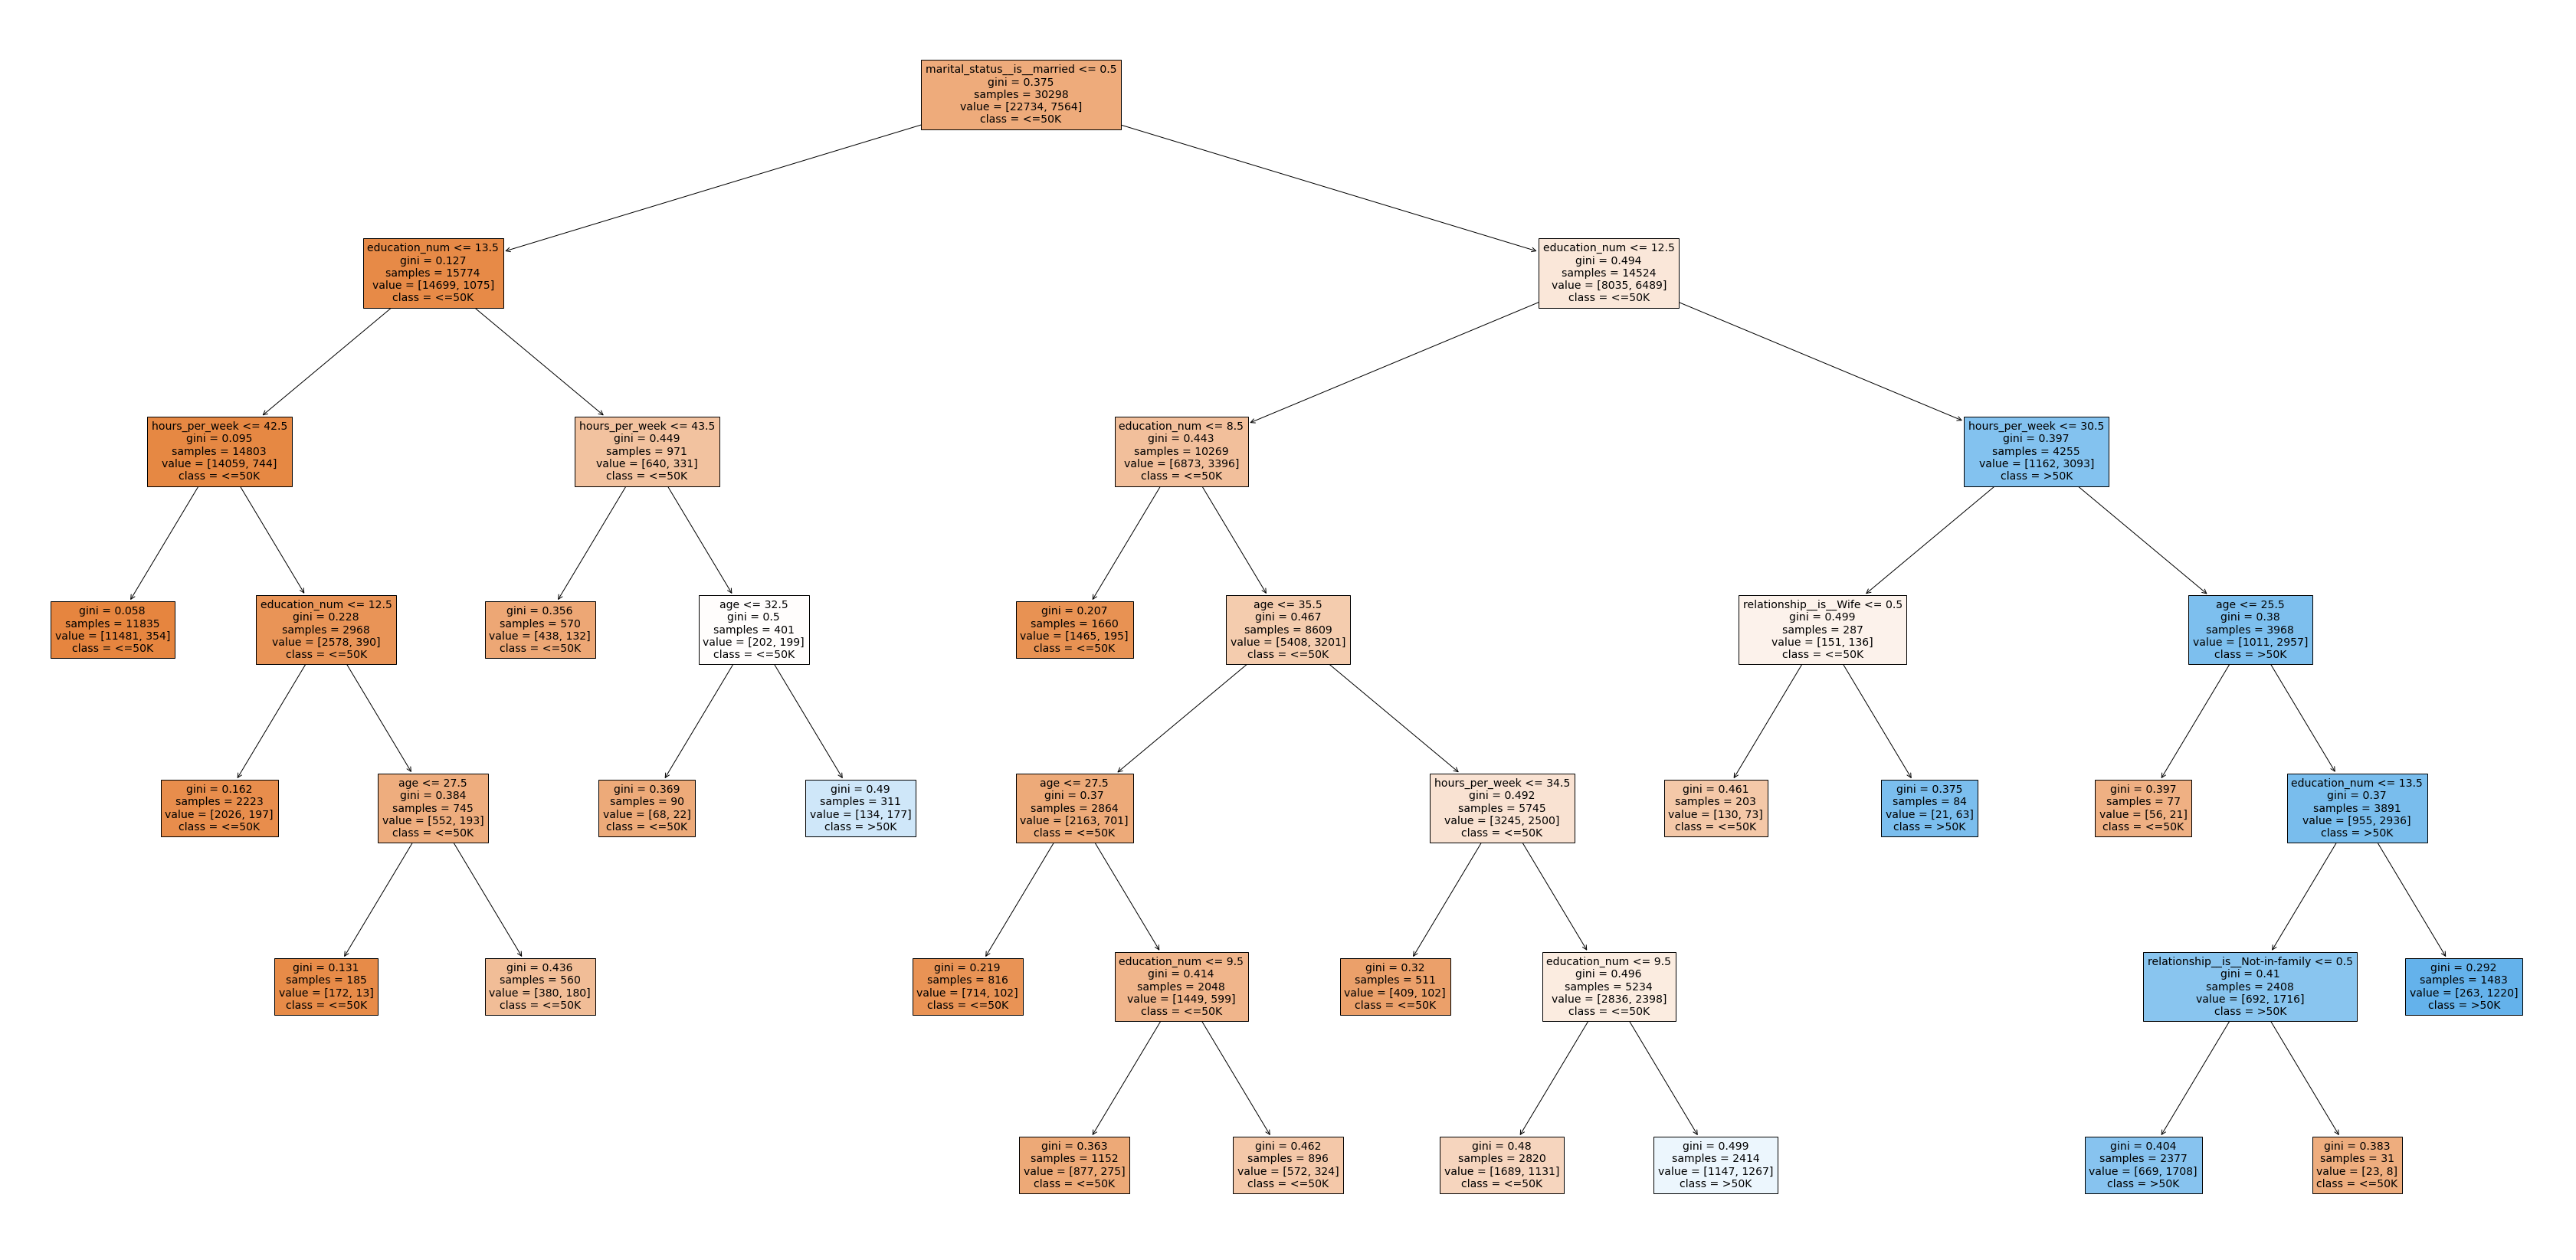

In [27]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60,30))
plot_tree(dt, feature_names=encoded_feature_names, class_names=["<=50K", ">50K"], filled=True)
plt.show()

### 2.2 Local interpretation 

How could you use the model drawing to interpret locally one output ?

follow the tree according to specific sample data point features values

## 3. Partial dependence plot 

Draw the partial dependence plot of the decision tree model dt trained above. 

Following this morning typology of XAI method (global/local, black-box/white-box), how can be classified the PDP? 

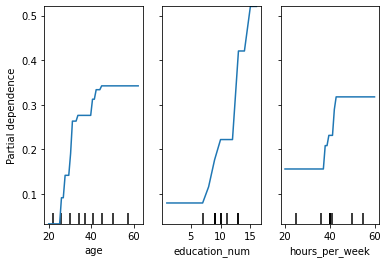

In [44]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(dt, X_train, features=[0, 1, 2], grid_resolution=50)

## 4.  Local Interpretable Model-agnostic Explanations (LIME)

LIME is a popular explanation method discovered in 2016 by Marco Tulio Ribeiro. 

"An essential criterion for explanation is **local fidelity**. Although it is often impossible for an explanation to be completely faithful unless it is the complete description of the model itself, for an explanation to be meaningful it must at least be locally faithful, i.e. it must correspond to how the model behaves in the vicinity of the instance being predicted. We note that local fidelity does not imply global fidelity: features that are globally important may not be important in the local context, and vice versa. While global fidelity would imply local fidelity, identifying globally faithful explanations that are interpretable remains a challenge for complex models. 

An explainer should be able to explain any model, and thus be **model-agnostic** (i.e. treat the original model as a black box). Apart from the fact that many state-of-the-art classifiers are not currently interpretable, this also provides flexibility to explain future classifiers."

Original paper is available here: https://arxiv.org/pdf/1602.04938.pdf (recommended). 

According to this extract how should be classified LIME in the typology of explanation method? 

### 4.1 Step 1: sampling around an instance 

The first step toward a LIME-like explainer is to create a function capable of creating samples in the vicinity of any instance for the x space (data point). 

While there are several ways of acheiving this objective, we will focus today on the simplest one : random perturbation according to a gaussian distribution. Starting from an instance $X_{poe}$, point-of-interest, that we wish to explain, we create a dataset of the form $X_{poe} + \epsilon$ where $\epsilon \sim N(0, \sigma)$. Note that this approach only works with numerical data. 

Train a decision tree with only numerical features, it will play the role of our black-box model to be explained

In [31]:
numerical_data = [x for x in feature_names if x not in categorical_features]

# Train random forest 
X_train, X_test, y_train, y_test = train_test_split(data[numerical_data], y, test_size=.33)
dt = DecisionTreeClassifier(max_leaf_nodes=20)
dt.fit(X_train, y_train)
print("Accuracy score (test dataset): ", accuracy_score(y_test, dt.predict(X_test)))

Accuracy score (test dataset):  0.7956982042347897


Create a function that takes as argument $X_{poe}$ and that return a dataset containing k $X_{poe} + \epsilon$ where $\epsilon \sim N(0, \sigma)$ elements. 

In [45]:
import numpy as np

def generate_samples_around_instance(instance, k, sigma):
    """
    Generate k samples in the vicinity of the given instance using random perturbation with a Gaussian distribution.
    
    Parameters:
    instance (numpy array): the instance around which to generate samples
    k (int): the number of samples to generate
    sigma (float): the standard deviation of the Gaussian distribution
    
    Returns:
    numpy array: a dataset containing k samples in the vicinity of the instance
    """
    samples = np.zeros((k, len(instance)))
    for i in range(k):
        samples[i] = instance + np.random.normal(scale=sigma, size=len(instance))
    return samples

instance = X_test.iloc[0].values  # select a test instance
k = 100  # number of samples to generate
sigma = 0.1  # standard deviation of the Gaussian distribution
samples = generate_samples_around_instance(instance, k, sigma)
samples

array([[36.97990095,  9.03945816, 40.01116895],
       [37.09537734,  9.09786008, 40.1498409 ],
       [36.9993914 ,  8.94305321, 39.90118764],
       [36.89765589,  9.1737787 , 40.00862614],
       [37.05837673,  8.8725    , 40.05145554],
       [37.10866142,  9.06173672, 40.04598839],
       [36.88263943,  8.84577345, 39.95568131],
       [37.03534451,  9.04275209, 40.02610657],
       [37.03479071,  9.03557267, 39.94684079],
       [36.9199726 ,  8.92966683, 39.91844767],
       [36.96712035,  9.07561958, 40.14799171],
       [37.14898455,  8.8640281 , 40.20921637],
       [36.85207932,  9.10406535, 40.00343841],
       [37.00376404,  8.82607078, 40.05969392],
       [37.05155948,  8.89582911, 39.98803133],
       [37.08080698,  8.97539518, 40.15278134],
       [37.0908655 ,  9.23576297, 39.96356952],
       [37.20239454,  8.87107483, 39.99891951],
       [37.02812691,  8.90136972, 39.93041081],
       [37.02284932,  8.97991636, 39.91253784],
       [36.79805242,  9.23849397, 39.842

### Step 2: train an interpretable classifier on these samples 

The second step to obtain a LIME-like classifier is to train an interpretable model on these samples. Although the black-box model may be globally very complex on the entire feature space, we can assume that it can be approximated locally with a very simple model. Then this simple model will inform us on the most significative features in the vicinity of $X_{poe}$. 

Today, for the sake of simplicity, we will us a linear model (Lasso) as our interpretable model. 

Train a linear regression on the samples and interpret the coefficient to have a local explanation. You may use results of the part 1 to help you. 

In [48]:
from sklearn.linear_model import Lasso

def get_nearby_samples(X_poie, sigma, k):
    nearby_samples = np.empty((k, X_poie.shape[1]))
    for i in range(k):
        nearby_samples[i] = X_poie + np.random.normal(0, sigma, size=X_poie.shape).reshape(X_poie.shape)
    return nearby_samples

X_poie = data.iloc[0][numerical_data].values.reshape(1, -1)
nearby_samples = get_nearby_samples(X_poie, sigma=0.1, k=100)

# Train Lasso linear regression
lasso = Lasso(alpha=0.01)
lasso.fit(nearby_samples, [dt.predict(x.reshape(1, -1))[0] for x in nearby_samples])

# Interpret coefficients
coefs = lasso.coef_
intercept = lasso.intercept_

# Print local explanation
print("Local explanation for point of interest:\n")
for i, coef in enumerate(coefs):
    if coef != 0:
        print(f"{numerical_data[i]}: {coef}")
print(f"\nIntercept: {intercept}")


Local explanation for point of interest:


Intercept: 0.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


Questions : 
  - how you would interpret this explanation? 
  - what are the effects of the parameters k, sigma and alpha on the final explanation? 

Bonus : 
  - find alternative ways of sampling in the vicinity of $X_{poe}$ and explain the differences with gaussian_sampling 
  - find alternative interpretable models 
  - create a datavizualization of the sampling and intertable model steps 